In [1]:
import pickle
import os
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import sys
import math

%matplotlib inline
import matplotlib.pyplot as plt
from ipywidgets import *
from IPython.display import display

plt.rcParams["figure.figsize"] = (10, 6)

# Магия, чтобы модуль experimental_net импортировался заново при изменениях в нём.
%reload_ext autoreload
%autoreload 2

import toy_net as nn

toy_net reload
toy_net.common reload
toy_net.functions reload
toy_net.optimizers reload
toy_net.net reload


In [2]:
cifar_folder = 'data/cifar-10-batches-py'

labels_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 
    'frog', 'horse', 'ship', 'truck']
label_count = len(labels_names)
print(labels_names)

def load_cifar_batch(folder, file):
    with open(os.path.join(folder, file), 'rb') as f:
        dict = pickle.load(f, encoding='bytes')
    print(dict[b'batch_label'])
    return dict[b'data'], np.array(dict[b'labels'])

def load_cifar(folder):
    x_tr = list()
    y_tr = list()
    for i in range(1, 6):
        x, y = load_cifar_batch(folder, 'data_batch_' + str(i))
        x_tr.append(x)
        y_tr.append(y)
    x_tr = np.concatenate(x_tr)
    y_tr = np.concatenate(y_tr)
    x_te, y_te = load_cifar_batch(folder, 'test_batch')
    return x_tr, y_tr, x_te, y_te

x_tr, y_tr, x_te, y_te = load_cifar(cifar_folder)
print(x_tr.shape, y_tr.shape, x_te.shape, y_te.shape)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
b'training batch 1 of 5'
b'training batch 2 of 5'
b'training batch 3 of 5'
b'training batch 4 of 5'
b'training batch 5 of 5'
b'testing batch 1 of 1'
(50000, 3072) (50000,) (10000, 3072) (10000,)


In [3]:
def plot_image(x, y):
    plt.imshow(x.reshape(3, 32, 32).transpose(1, 2, 0) / 256)
    plt.title(labels_names[y])
    plt.axis('off')

def show_image(x, y):
    plot_image(x, y)
    plt.show()

def show_images(xs, ys):
    n = len(xs)
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plot_image(xs[i], ys[i])
    plt.show()

def show_train_images(pos):
    show_images(x_tr[pos:pos+5], y_tr[pos:pos+5])

silence = interact(show_train_images, 
        pos=widgets.BoundedIntText(min=0, max=49999, step=5, value=0, description='Range start:'))

A Jupyter Widget

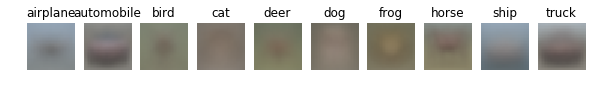

In [4]:
y_mean = range(10)
x_mean = [x_tr[y_tr == y].mean(axis=0) for y in y_mean]
show_images(x_mean, y_mean)

In [5]:
# Perform one hot encoding
y_tr_n = np.eye(label_count)[y_tr]
y_te_n = np.eye(label_count)[y_te]

print(y_tr_n.shape)
print(y_te_n.shape)

x_tr_n = x_tr / 256 - 0.5
x_te_n = x_te / 256 - 0.5

(50000, 10)
(10000, 10)


In [96]:
# Сетка

np.random.seed(5)

reg2 = 0.1
reg2_constrain = None
reg3 = None

functions = [
    nn.Matrix(x_tr_n.shape[1], 50, reg2=reg2, reg3=reg3, reg2_constrain=reg2_constrain),
    nn.Bias(50, reg2=reg2, reg3=reg3),
    nn.BatchNorm(),
    nn.Tanh(),

    nn.Matrix(50, label_count, reg2=reg2, reg3=reg3, reg2_constrain=reg2_constrain),
    nn.Bias(label_count, reg2=reg2, reg3=reg3),
    #nn.BatchNorm(),
    #nn.SoftMax(),
    #nn.EntropyLoss()
    nn.SvmLoss()
]

net, layers = nn.build_sequence_net(functions, nn.Adam())

In [97]:
output = widgets.Output()
output.layout.height = '380px'
#output.layout.height = '100px'
display(output)

def show_matrix_images(w):
    images = w.transpose() * 10000 + 128
    images = np.minimum(255, np.maximum(0, images))
    image_count = images.shape[0]
    column_count = 10
    image_count = min(image_count, 50)
    row_count = math.ceil(image_count / column_count)
    global output
    output.clear_output()
    with(output):
        for i in range(image_count):
            image = images[i]
            plt.subplot(row_count, column_count, i + 1)
            plt.imshow(image.reshape(3, 32, 32).transpose(1, 2, 0) / 256)
            plt.axis('off')
        plt.show()


A Jupyter Widget

In [98]:
def train_epoch(net, speed):
    loss_before = net.calculate_loss([x_tr_n], y_tr_n)
    
    batch_size = 1000
    train_len = x_tr_n.shape[0]
    for i in range(0, train_len // batch_size):
        batch_start = i * batch_size
        batch_end = min(train_len, batch_start + batch_size)
        x_batch = x_tr_n[batch_start:batch_end]
        y_batch = y_tr_n[batch_start:batch_end]

        loss = net.train([x_batch], y_batch, speed)

        sys.stdout.write('\rTrain. Batch: %d, loss %f' % (i, loss))
        sys.stdout.flush()

    loss_after = net.calculate_loss([x_tr_n], y_tr_n)
    sys.stdout.write('\rEpoch complete. Loss before: %f, after: %f, change: %f\n' 
        % (loss_before, loss_after, loss_after - loss_before))
    sys.stdout.flush()
    print('Accuracy tr:', net.calculate_accuracy([x_tr_n], y_tr_n))
    print('Accuracy te:', net.calculate_accuracy([x_te_n], y_te_n))

first_matrix = functions[0]
print(first_matrix.trace_statistics(x_tr_n))
show_matrix_images(first_matrix.w)

for i in range(3):
    train_epoch(net, 0.001)

    print(first_matrix.trace_statistics(x_tr_n))
    show_matrix_images(first_matrix.w)


Matrix statistics:
  column std log10 min: -1.75, max: -1.72
  y std log10 min: -0.78, max: -0.38
Epoch complete. Loss before: 9.615745, after: 4.514400, change: -5.101345
Accuracy tr: 0.37838
Accuracy te: 0.3747
Matrix statistics:
  column std log10 min: -2.13, max: -1.82
  y std log10 min: -0.53, max: 0.12
Epoch complete. Loss before: 4.514400, after: 4.333730, change: -0.180670
Accuracy tr: 0.39794
Accuracy te: 0.3943
Matrix statistics:
  column std log10 min: -2.56, max: -1.98
  y std log10 min: -0.61, max: 0.08
Epoch complete. Loss before: 4.333730, after: 4.287142, change: -0.046588
Accuracy tr: 0.40104
Accuracy te: 0.3925
Matrix statistics:
  column std log10 min: -2.70, max: -2.11
  y std log10 min: -0.57, max: 0.05


In [95]:
print(layers[-1])

data:
  x:
    [[ 0.63239296  0.5876206   1.17968719 ...,  0.34766878  0.44007847
       0.00765725]
     [ 0.78137355 -0.2844227  -0.73006735 ..., -0.84853456  1.07729487
      -0.35255179]
     [-1.51810503  0.63777317  0.48760237 ...,  0.01603228  0.29400832
      -0.67753494]
     ..., 
     [-2.30853222  0.30161015  1.1007816  ...,  0.08774935  0.81858223
       0.16509569]
     [-0.17903584 -0.59365158 -0.47264061 ...,  0.09058873 -0.64268158
       0.12899371]
     [-1.03486125  0.90661056  0.38386685 ..., -0.57303088 -0.94976881
      -1.44548607]]
  y:
    [  1.40581408e-02   1.09295411e-02   1.62402233e-02   1.42880498e-02
       5.29701744e-04   1.31936300e-02   1.16859694e-02   1.50359470e-02
       1.61627242e-02   4.54575902e-03   1.48327255e-02   1.01902027e-02
       9.39124321e-03   2.40053176e-02   1.41739306e-03   5.69226787e-03
       9.48139807e-03   9.54109769e-03   1.50266783e-02   1.18570097e-02
       8.93271189e-03   7.90854698e-03   5.00926250e-03   1.0232097